# SETS

A counterfactual explanation, originally introduced to machine learning by [1], answers the question "what if" by building counterexamples. Based on an input instance $x$, the goal is to find a counterfactual $x^{cf}$ close to the original instance $x$ but differently classified $y \neq y^{cf}$ by a predictor $f$. The intention is to visualize boundary cases. Further research has shown that counterfactual explanations are easy to understand for humans because they are intuitive  to human thinking by showing counterexamples.  

Shapelet-based Temporal Association Rule Mining for Multivariate Time Series Classification developed by Bahri et al. [1] builds counterfactuals in multivariate setting by perturbing the features of a time series with the help of a shapelet algorithm. Hereby they extract the most prominent class shapelets using an adaption of the shapelet transform algorithm of [2] implemented in sktime. The algorithm is adapted to multivariate timeseries analysis, treating each dimension as a univariate timeseries and information gain. The algorithm imputes the shapelets based on prior observed occcurences and shapelet quality. If a single shapelet does not cause a counterfactual prediction, more perturbations in other dimensions or other parts of the timeseries are performed. 


<img src="https://fzi-forschungszentrum-informatik.github.io/TSInterpret/Notebooks/SETS_CF.png" alt="Visualization of SETS_CF" style="width: 800px;" />



Visualization of SETS from the original paper [1]; The code in TSInterpret is based on the authors <a href='https://github.com/omarbahri/SETS'>implementation </a>.

[1] Omar Bahri and Soukaina Filali Boubrahimi and Shah Muhammad Hamdi.Shapelet-Based Counterfactual Explanations for Multivariate Time Series. 2022 ACM SIGKDD Workshop on Mining and Learning from Time Series. arXiv:2208.10462 URL:https://arxiv.org/abs/2208.10462 (visited on 2023-12-04)


[2] Hills, Jon and Lines, Jason and Baranauskas, Edgaras and Mapp, James and Bagnall, Anthony. Classification of time series by shapelet transformation. Data Mining and Knowledge Discovery. Harv. JL & Tech. 31 (2017): 841.

In [1]:
! pip install .
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd
import numpy as np
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
from sklearn import tree
from sklearn.model_selection import cross_val_score
from pymop import Problem
import os
from tslearn.datasets import UCR_UEA_datasets
import warnings
warnings.filterwarnings('ignore')
import pickle
import sklearn

ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


## Load Data and Model
- Load Data and reshape the data to fit a 1D-Conv Convolutional Neural Network (CNN). Note that the input for a 1D-Conv CNN hat the shape (batch, timesteps, features).
- Load Model with Pretrained Weigths. 

In [2]:
dataset='GunPoint'
X_train,train_y,X_test,test_y=UCR_UEA_datasets().load_dataset(dataset)
train_x=np.swapaxes(X_train,1,2)#.reshape(-1,X_train.shape[-1],X_train.shape[-2])
test_x=np.swapaxes(X_test,1,2)#.reshape(-1,X_train.shape[-1],X_train.shape[-2])
#enc1=pickle.load(open(f'../../ClassificationModels//models/{dataset}/OneHotEncoder.pkl','rb'))
#enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
#test_y=enc1.transform(test_y.reshape(-1,1))
#train_y=enc1.transform(train_y.reshape(-1,1))
n_classes = len(np.unique(test_y))



In [3]:
n_classes

2

In [4]:
from ClassificationModels.CNN_T import ResNetBaseline, UCRDataset, get_all_preds, fit
stride = 1
kernel_size=10
padding = kernel_size - 1
input_size= train_x.shape[-1]
device = torch.device( "cpu")#"cuda:0" if torch.cuda.is_available() else
model = ResNetBaseline(in_channels= 1, num_pred_classes=n_classes)

model.load_state_dict(torch.load(f'../../ClassificationModels/models/{dataset}/ResNet'))
#torch.save(model.state_dict(), f'../../ClassificationModels/models/{dataset}/ResNet')
test_dataset = UCRDataset(test_x,test_y)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=True)
model.eval()
y_pred,labels= get_all_preds(model,test_loader)


In [5]:
train_y_pred= np.argmax(model(torch.from_numpy(train_x).float()).detach().numpy(),axis=1)

## Interpretability Algorithm

Using a interpretability algorithm consists of 4 steps:

1. Load the Interpretability Method
2. Instaniate the Method with the desired Parameters
3. Call the explain Method
4. Plot the results

### 1. & 2. Loading & Initialization

SETS works on all models returning a probability function. The Initialization takes the following arguments:

    `model`: The model to be explaines.
    `data`: Tuple of Data and Labels.
    `backend`: `PYT`, `SK`, or `TF`.
    `mode`: second dimension is either `feat` or `time`. 
    `method`: Optimization Method either `brut` or `opt`.
    `min_shapelet_len` : Value for min length of extracted shapelets 
    `max_shapelet_len`: Value for max length of extracted shapelets
    `time_contract_in_mins_per_dim` : Max time for shapelet extraction per dimension
    `initial_num_shapelets_per_case` : Initial number of shapelets per case.

### For Univariate ECG200 Case

In [6]:
%load_ext autoreload
%autoreload 2

from TSInterpret.InterpretabilityModels.counterfactual.SETSCF import SETSCF

#train_x, train_y, test_x, test_y = X_train,train_y,X_test,test_y

# Note: this is for demonstration purposes, time contract per minutes should be adjusted for better results! 
exp_model= SETSCF(model,
                  (train_x, train_y_pred),
                  backend='PYT',
                  mode='feat',  
                  min_shapelet_len=2,
                  max_shapelet_len=30,
                  time_contract_in_mins_per_dim=1,
                  #initial_num_shapelets_per_case=10,
                  fit_shapelets = False )


E0000 00:00:1732204223.641479  154524 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732204223.644140  154524 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(50, 1, 150)
(50, 1)
Extract Shapelets with information gain rejection lvl 0.001 and shapelets per class of 30


In [7]:
train_x.shape

(50, 1, 150)

### 3. Call the fit method.

This method is optional! If shapelets are already exctracted, please specify here the occlusion threshhold and if shapelets belonging to multiple classes should be retained. 
This method is called by default if the explain_model is fitted. 


In [8]:
exp_model.fit(occlusion_threshhold=1e-1,remove_multiclass_shapelets=True)
 

Fit function to prune shapelets with occlusion threshhold of 0.1 and remove shapelets belonging to more than one class set to True
Shapelet by index per class and dimension: {0: [[0, 2, 3, 4, 5, 8, 9, 10, 12, 13, 14, 17, 19, 21, 22, 23, 27, 31, 32, 33, 34, 35, 38, 42, 43, 44, 45, 49, 50]], 1: [[1, 6, 7, 11, 15, 16, 18, 20, 24, 25, 26, 28, 29, 30, 36, 37, 39, 40, 41, 46, 47, 48, 51, 52, 53, 54, 55, 56]]}


([[array([[ 2.07412137,  1.78661087,  1.52706437,  1.24155846,  0.96232311,
            0.66670469,  0.35323928,  0.07664767, -0.11537869, -0.37408378,
           -0.48967512, -0.60443992, -0.71324848, -0.78989338, -0.85678703,
           -0.90713158, -0.93818705, -0.94386301, -0.96763889, -0.98794289]]),
   array([[-0.43513278, -0.41887158, -0.43066745, -0.42836311, -0.42640321,
           -0.43004133, -0.43354442, -0.44051036, -0.43549058, -0.43791989,
           -0.43017589, -0.44178965, -0.44465533, -0.43752702, -0.44063203,
           -0.44184122, -0.37396217, -0.08844278,  0.39915161,  1.27394411,
            2.34368053,  3.39919456]]),
   array([[-1.68529417, -1.38751558, -1.0463456 , -0.74039696, -0.50904518,
           -0.4112656 , -0.34122971, -0.31891533, -0.30887492, -0.29607386,
           -0.32303391, -0.32013368, -0.29175416, -0.23395223, -0.23393649,
           -0.21326463, -0.16984672, -0.10185282, -0.02887912,  0.07453565,
            0.2431238 ,  0.63724006,  1.12237

In [9]:
exp_model.all_heat_maps

{0: [{0: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
   2: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [10]:
exp_model.all_shapelets_class

{0: [[0,
   2,
   3,
   4,
   5,
   8,
   9,
   10,
   12,
   13,
   14,
   17,
   19,
   21,
   22,
   23,
   27,
   31,
   32,
   33,
   34,
   35,
   38,
   42,
   43,
   44,
   45,
   49,
   50]],
 1: [[1,
   6,
   7,
   11,
   15,
   16,
   18,
   20,
   24,
   25,
   26,
   28,
   29,
   30,
   36,
   37,
   39,
   40,
   41,
   46,
   47,
   48,
   51,
   52,
   53,
   54,
   55,
   56]]}

In [11]:
np.argmax(model(torch.from_numpy(test_x).float()).detach().numpy(),axis=1)

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0])


### 4. Call the explain method.

Prepeare the instance and the predicted label of the instance as parameters for the explain methods.

- `item`: item to be explained

In [12]:
ts = 2
test_y[ts]
print(model(torch.from_numpy(test_x[ts][np.newaxis,:]).float()))
cf_explanation, label = exp_model.explain(test_x[ts], target = None)

tensor([[-25.9259,  28.3633]], grad_fn=<AddmmBackward0>)
threshold  0.0
shapelet distance     0    1    2         3         4         5         6         7         8   \
0  4.0  4.0  4.0  0.562663  3.783569  3.890261  0.242808  3.922793  0.797091   

         9   ...        50        51       52        53        54        55  \
0  1.142821  ...  0.364907  0.603182  0.78962  2.569785  3.939782  0.152305   

         56        57        58        59  
0  0.486765  0.402134  0.006526  3.086924  

[1 rows x 60 columns]
shapelet distance (1, 60)
tslength 150
Threshold 0.0
dim  0
0     4.000000
1     4.000000
2     4.000000
3     0.562663
4     3.783569
5     3.890261
6     0.242808
7     3.922793
8     0.797091
9     1.142821
10    0.483475
11    0.379737
12    0.492401
13    3.770445
14    0.809210
15    3.595331
16    3.838384
17    0.385663
18    3.932936
19    1.094521
20    0.300650
21    3.966649
22    0.498008
23    0.218924
24    3.161522
25    0.930925
26    1.076742
27    3.759451

AttributeError: 'float' object has no attribute 'shape'

### 4. Visualization

All plot function take as input the item to be explained and the returned explanation. As as additonal option a figsize can be given.


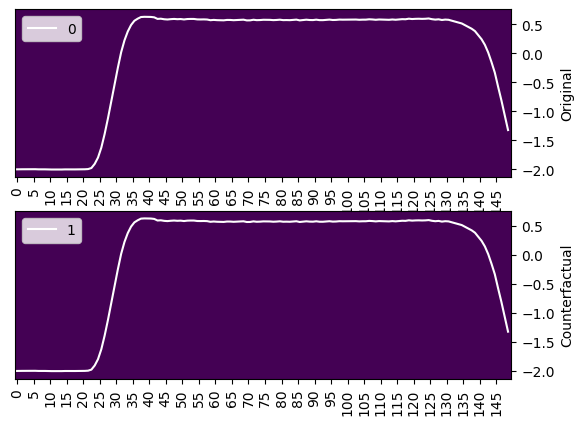

In [ ]:
exp_model.plot(
        test_x[ts],
        y_pred[ts],
        cf_explanation,
        label,
        vis_change=True,
        all_in_one=False,
        save_fig=None,
        figsize=(6.4, 4.8))

### Multivariate Case

In [ ]:
import sklearn
dataset='BasicMotions'
X_train,train_y,X_test,test_y=UCR_UEA_datasets().load_dataset(dataset)
train_x=np.swapaxes(X_train,2,1)
test_x=np.swapaxes(X_test,2,1)


n_classes = len(np.unique(test_y))


In [ ]:
n_classes

In [ ]:
from ClassificationModels.CNN_T import ResNetBaseline, UCRDataset, get_all_preds
from ClassificationModels.LSTM_T import LSTM

#device = torch.device( "cpu")#"cuda:0" if torch.cuda.is_available() else
model = ResNetBaseline(in_channels=train_x.shape[1], num_pred_classes=n_classes)
model.load_state_dict(torch.load(f'../../ClassificationModels//models/{dataset}/ResNet'))
test_dataset = UCRDataset(test_x,test_y)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=True)

In [ ]:
np.argmax(model(torch.from_numpy(test_x).float()).detach().numpy(),axis=1)

In [ ]:
model.eval()

In [ ]:
y_pred=model(torch.from_numpy(train_x).float()).detach().numpy()
train_y=np.argmax(y_pred,axis=1)


In [ ]:
%load_ext autoreload
%autoreload 2

from TSInterpret.InterpretabilityModels.counterfactual.SETSCF import SETSCF
exp_model= SETSCF(model,
                  (train_x,train_y),
                  backend='PYT',
                  mode='feat',         
                  min_shapelet_len=3,
                  max_shapelet_len=20,
                  time_contract_in_mins_per_dim=1,
                  #initial_num_shapelets_per_case=10,
                  fit_shapelets = False)

In [ ]:
exp_model.fit(occlusion_threshhold=3e-1,remove_multiclass_shapelets=False)

In [ ]:
exp_model.all_heat_maps

In [ ]:
exp_model.all_shapelets_class

In [ ]:
ts = 4
cf_explanation, label = exp_model.explain(train_x[ts],target=3
                                     )

In [ ]:
np.argmax(y_pred,axis=1)

In [ ]:
#item, org_label, exp, cf_label, save_fig=None, figsize=(6.4, 4.8)
exp_model.plot_in_one(train_x[ts],np.argmax(y_pred[ts]),cf_explanation,label,figsize=(15,15))